## Paris Agreement Scenario: 66% chance of staying below 2ºC

In [16]:
using PyPlot
using Random
using Distributions
using JuMP, Ipopt

In [17]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

In [18]:
# Model domain
dt = 1.
t = Array(2020:dt:2200);

economics = Economics(t);

In [19]:
Random.seed!(1)
d = Normal(0.65, 0.13)
Nsamples = 5000
feedback_samples = rand(d, Nsamples)

feedback_samples = feedback_samples[(feedback_samples .> 0.) .& (feedback_samples .<= 0.999)]
print("Filtered out ",Nsamples-length(feedback_samples), " unphysical samples.")

ECS₀ = 1.2
ECS_samples = ECS₀ ./ (1. .-feedback_samples);

Filtered out 23 unphysical samples.

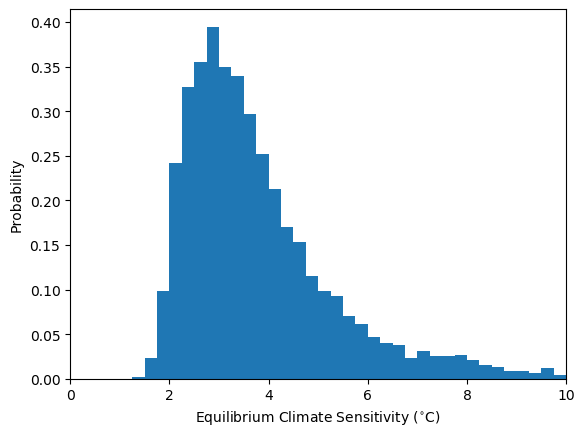

In [20]:
hist(ECS_samples, bins=0.:0.25:10., density=true)
xlim([0,10])
xlabel(L"Equilibrium Climate Sensitivity ($^{\circ}$C)")
ylabel("Probability");

In [21]:
ECS_threshold = quantile(ECS_samples, 2. /3.)

present_year = 2020.
name = "66.6% below";
controls = init_linear_controls(t);

model_threshold = ClimateModel(name, t, dt, present_year, economics, Physics(ECS_threshold), controls);
optimize_controls!(model_threshold, obj_option="temp", temp_goal = 2.);

Found optimal solution for model name: 66.6% below

In [22]:
ensemble = Dict{String, ClimateModel}();
first = true

for member_id in 1:length(ECS_samples)
    present_year = 2020.
    ECS = ECS_samples[member_id]
    name = "member $member_id";
    controls = model_threshold.controls;
    model = ClimateModel(name, t, dt, present_year, economics, Physics(ECS), controls);
    ensemble[name] = model
end

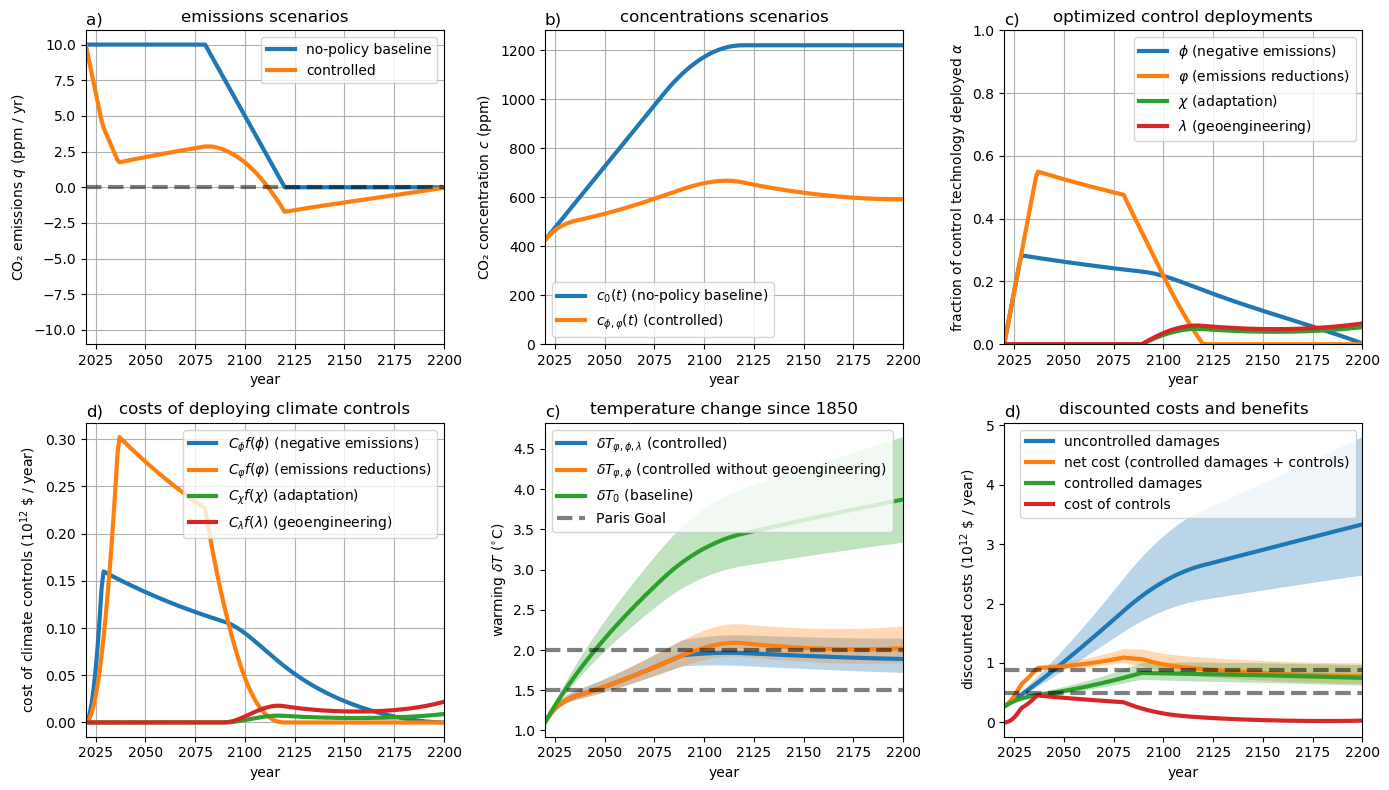

In [23]:
plot_ensemble(ensemble)
savefig("../figures/Paris_Agreement_example.png", bbox_inches="tight", dpi=100)